## FIN_GAN

Epoch [1/5000], D Loss: 1.3922, G Loss: 0.6542
Epoch [2/5000], D Loss: 1.3895, G Loss: 0.6562
Epoch [3/5000], D Loss: 1.3868, G Loss: 0.6582
Epoch [4/5000], D Loss: 1.3841, G Loss: 0.6602
Epoch [5/5000], D Loss: 1.3814, G Loss: 0.6622
Epoch [6/5000], D Loss: 1.3787, G Loss: 0.6641
Epoch [7/5000], D Loss: 1.3761, G Loss: 0.6659
Epoch [8/5000], D Loss: 1.3735, G Loss: 0.6677
Epoch [9/5000], D Loss: 1.3710, G Loss: 0.6694
Epoch [10/5000], D Loss: 1.3684, G Loss: 0.6711
Epoch [11/5000], D Loss: 1.3659, G Loss: 0.6727
Epoch [12/5000], D Loss: 1.3633, G Loss: 0.6744
Epoch [13/5000], D Loss: 1.3606, G Loss: 0.6761
Epoch [14/5000], D Loss: 1.3580, G Loss: 0.6777
Epoch [15/5000], D Loss: 1.3552, G Loss: 0.6793
Epoch [16/5000], D Loss: 1.3524, G Loss: 0.6808
Epoch [17/5000], D Loss: 1.3495, G Loss: 0.6822
Epoch [18/5000], D Loss: 1.3466, G Loss: 0.6834
Epoch [19/5000], D Loss: 1.3437, G Loss: 0.6842
Epoch [20/5000], D Loss: 1.3415, G Loss: 0.6840
Epoch [21/5000], D Loss: 1.3402, G Loss: 0.6824
E

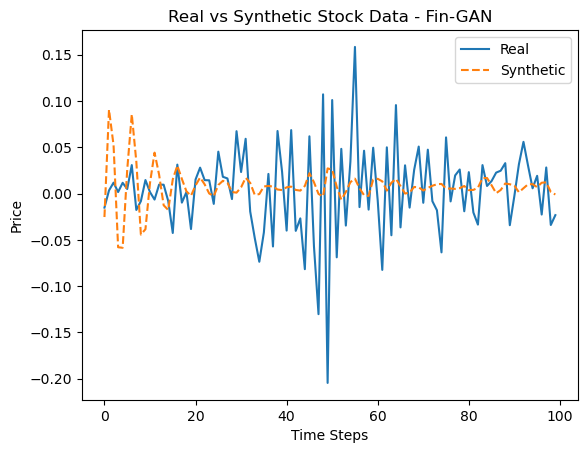

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from pathlib import Path

# 1. Prepare Data
def load_stock_data(file_name="nvidia_2020_2021.csv"):
    # Get the path relative to this script's location
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    # Read CSV with multi-index header (2 rows)
    df = pd.read_csv(file_path, header=[0,1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    # Access the 'Close' price for 'NVDA' ticker (second level)
    df['log_price'] = np.log(df[('Close', 'NVDA')])
    df['log_return'] = df['log_price'].diff()
    df.dropna(inplace=True)  # Drop NaN values
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_returns = scaler.fit_transform(df[['log_return']])  # Note: Double brackets for 2D input

    return scaled_returns, dates, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h).mean(dim=1)

# 3. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 100
lr = 0.0001
batch_size = 64
epochs = 5000

real_data, dates, scaler = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
generator = Generator(input_dim, hidden_dim, input_dim)
discriminator = Discriminator(input_dim, hidden_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# 4. Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)
        d_real = discriminator(real_seq)
        d_fake = discriminator(fake_seq.detach())
        d_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        d_fake = discriminator(fake_seq)
        g_loss = bce(d_fake, torch.ones_like(d_fake))
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# 5. Synthetic Data Generation
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_seq = generator(z).detach().cpu().numpy()
synthetic_seq = scaler.inverse_transform(synthetic_seq[0])

# Plot
plt.plot(scaler.inverse_transform(sequences[0].cpu().numpy()), label="Real", linestyle="-")
plt.plot(synthetic_seq, label="Synthetic", linestyle="--")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Real vs Synthetic Stock Data - Fin-GAN")
plt.show()


BASIC STATISTICS COMPARISON
       Real Returns  Synthetic Returns
count    100.000000         100.000000
mean       0.003521           0.007437
std        0.048509           0.020439
min       -0.204567          -0.062419
25%       -0.019606           0.001971
50%        0.006974           0.008054
75%        0.030337           0.011640
max        0.158454           0.096103


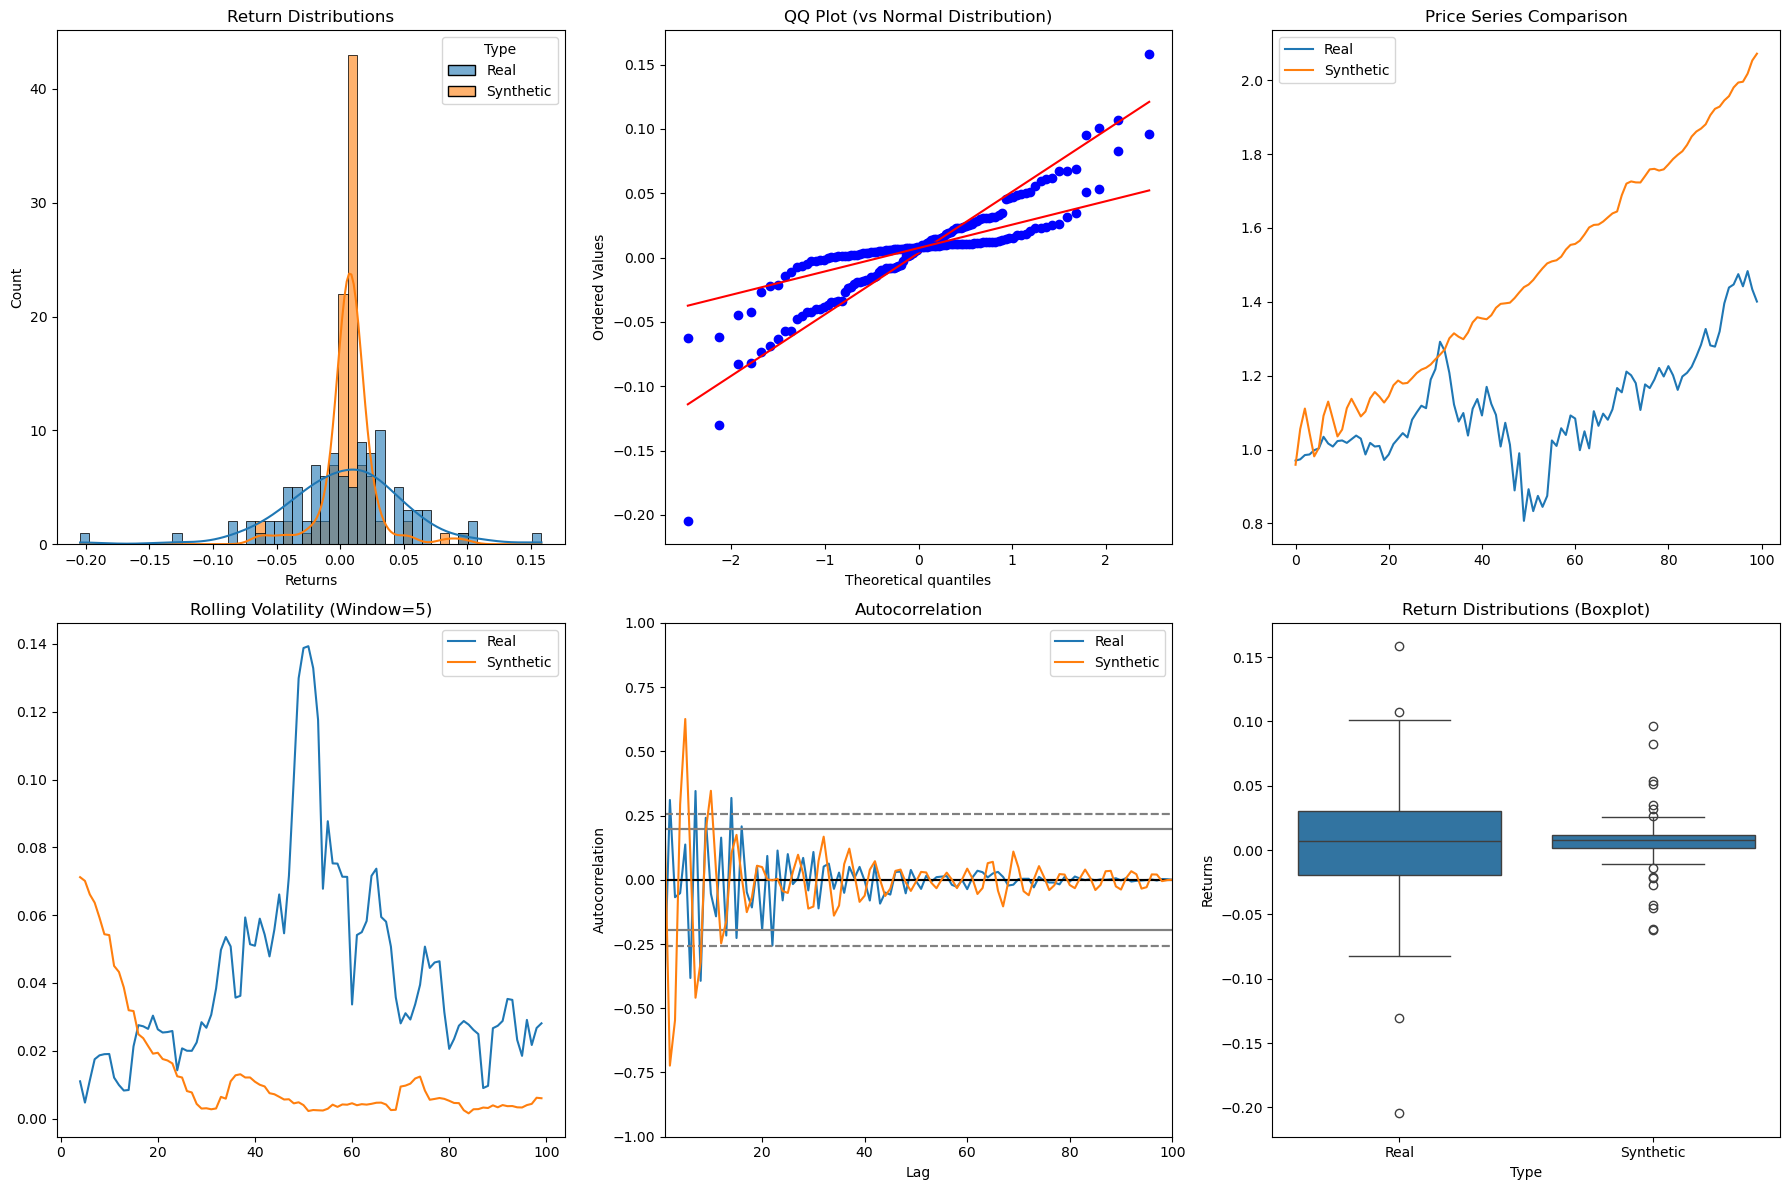


STATISTICAL TESTS
Kolmogorov-Smirnov Test:
	Statistic: 0.3200
	p-value: 0.0001

T-test:
	Statistic: -0.7438
	p-value: 0.4579

Jarque-Bera Test (Normality):
	Real: Stat=51.85, p=0.0000
	Synthetic: Stat=192.91, p=0.0000

Levene Test (Equal Variance):
	Statistic: 41.3160
	p-value: 0.0000

FINANCIAL METRICS COMPARISON
                           Real  Synthetic
Annualized Volatility  0.766194   0.322826
Sharpe Ratio           1.158190   5.805041
Max Drawdown          -0.411746  -0.120117
Kurtosis               3.338614   6.761872
Skewness              -0.569407   0.379307


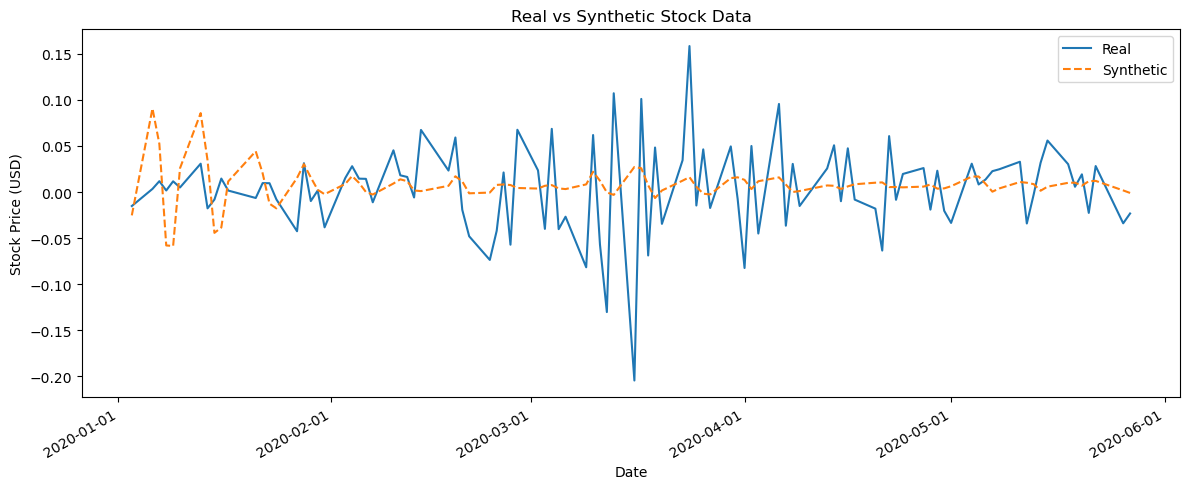

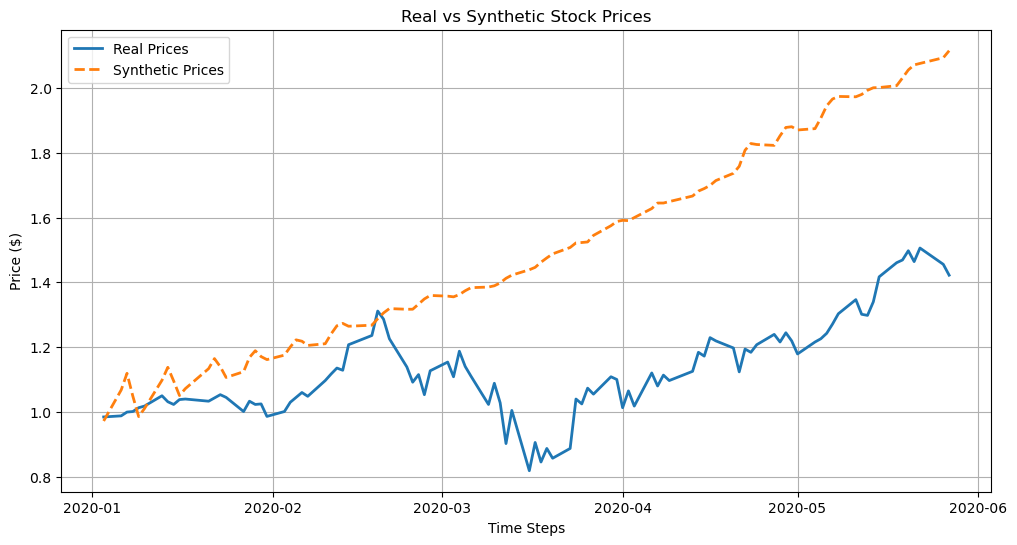

In [16]:
import matplotlib.dates as mdates

plot_dates = dates[:seq_len]

plt.figure(figsize=(12, 5))
plt.plot(plot_dates, scaler.inverse_transform(sequences[0].cpu().numpy()), label="Real", linestyle="-")
plt.plot(plot_dates, synthetic_seq, label="Synthetic", linestyle="--")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Real vs Synthetic Stock Data")
plt.legend()
plt.tight_layout()
plt.show()

# Generate synthetic data
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_log_returns = generator(z).detach().cpu().numpy()

# Inverse transformations for SYNTHETIC data
synthetic_log_returns = scaler.inverse_transform(synthetic_log_returns[0])  # (seq_len, 1)
synthetic_log_prices = np.cumsum(synthetic_log_returns, axis=0)  # Cumulative log returns
synthetic_prices = np.exp(synthetic_log_prices)  # Convert to actual prices

# Inverse transformations for REAL data
real_log_returns = scaler.inverse_transform(sequences[0].cpu().numpy())  # (seq_len, 1)
real_log_prices = np.cumsum(real_log_returns, axis=0)  # Cumulative log returns
real_prices = np.exp(real_log_prices)  # Convert to actual prices

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, real_prices, label="Real Prices", linewidth=2)
plt.plot(plot_dates, synthetic_prices, label="Synthetic Prices", linestyle='--', linewidth=2)
plt.title("Real vs Synthetic Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2540820/3460198721.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Returns',


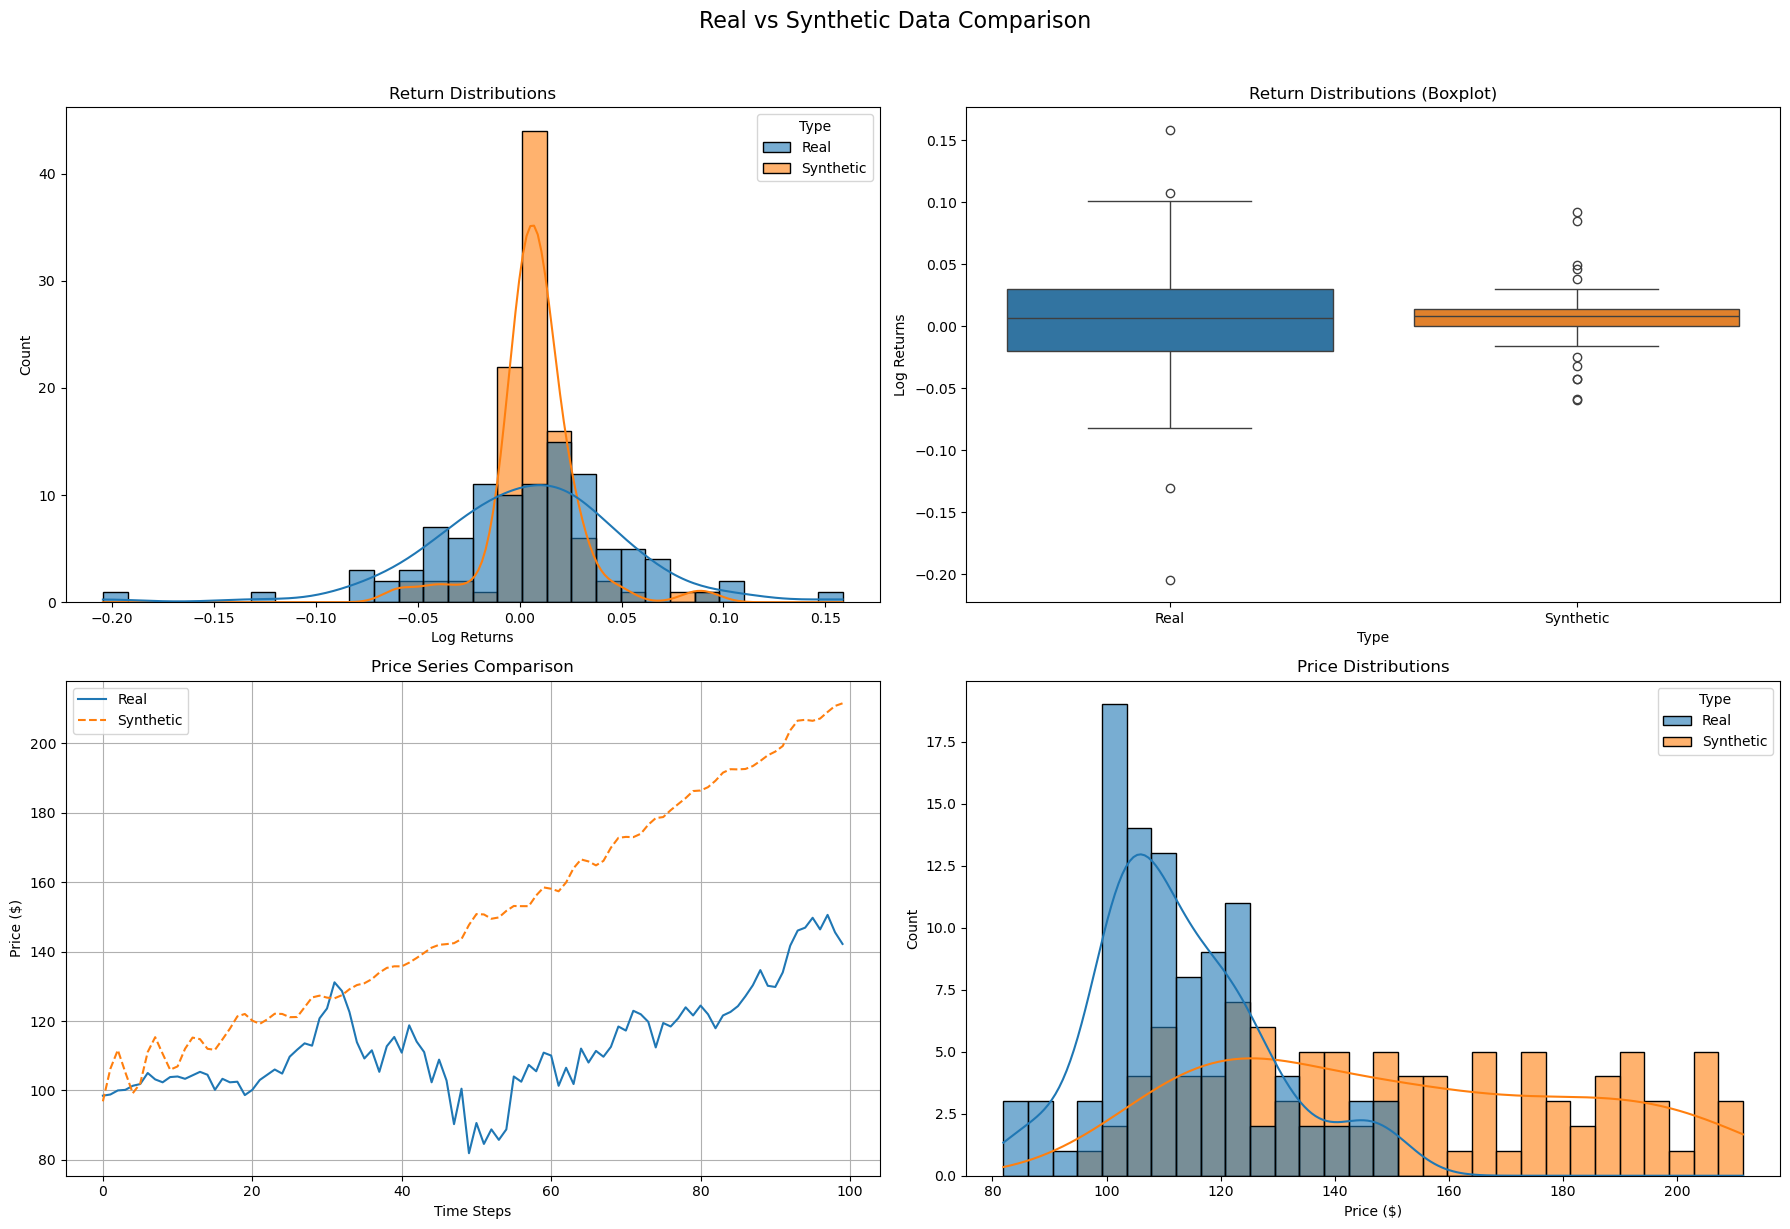


BASIC STATISTICS COMPARISON
       Real Returns  Synthetic Returns
count    100.000000         100.000000
mean       0.003521           0.007492
std        0.048509           0.020541
min       -0.204567          -0.059152
25%       -0.019606          -0.000041
50%        0.006974           0.007865
75%        0.030337           0.013495
max        0.158454           0.092328

STATISTICAL TESTS

Kolmogorov-Smirnov Test:
  Statistic: 0.3200
  p-value: 0.0001

T-test (Welch's):
  Statistic: -0.7538
  p-value: 0.4523


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_and_analyze(real_sequences, synthetic_returns, scaler):
    """
    Generate the 4 requested plots PLUS statistical comparisons
    """
    # Inverse transform real returns
    real_returns = scaler.inverse_transform(real_sequences[0].cpu().numpy())
    
    # Convert returns to prices
    def returns_to_prices(returns):
        log_prices = np.cumsum(returns)
        return np.exp(log_prices) * 100  # Using 100 as base price
    
    real_prices = returns_to_prices(real_returns)
    synthetic_prices = returns_to_prices(synthetic_returns)
    
    # Create DataFrames
    df = pd.DataFrame({
        'Returns': np.concatenate([real_returns.flatten(), synthetic_returns.flatten()]),
        'Prices': np.concatenate([real_prices.flatten(), synthetic_prices.flatten()]),
        'Type': ['Real']*len(real_returns) + ['Synthetic']*len(synthetic_returns)
    })
    
    # ======================
    # 1. Generate the Plots
    # ======================
    plt.figure(figsize=(18, 12))
    plt.suptitle('Real vs Synthetic Data Comparison', y=1.02, fontsize=16)
    
    # Plot 1: Return distributions (histogram)
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', 
                kde=True, bins=30, alpha=0.6, 
                palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions')
    plt.xlabel('Log Returns')
    plt.ylabel('Count')
    
    # Plot 2: Return distributions (boxplot)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns', 
               palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions (Boxplot)')
    plt.ylabel('Log Returns')
    
    # Plot 3: Price series comparison
    plt.subplot(2, 2, 3)
    plt.plot(real_prices, label='Real', color='#1f77b4')
    plt.plot(synthetic_prices, label='Synthetic', 
             linestyle='--', color='#ff7f0e')
    plt.title('Price Series Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Price distributions
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Prices', hue='Type', 
                kde=True, bins=30, alpha=0.6,
                palette=['#1f77b4', '#ff7f0e'])
    plt.title('Price Distributions')
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # ===========================
    # 2. Statistical Comparisons
    # ===========================
    print("\n" + "="*80)
    print("BASIC STATISTICS COMPARISON")
    print("="*80)
    
    # Calculate basic statistics
    stats_df = pd.DataFrame({
        'Real Returns': df[df['Type']=='Real']['Returns'].describe(),
        'Synthetic Returns': df[df['Type']=='Synthetic']['Returns'].describe()
    })
    print(stats_df)
    
    print("\n" + "="*80)
    print("STATISTICAL TESTS")
    print("="*80)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns']
    )
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.4f}")
    print(f"  p-value: {ks_p:.4f}")
    
    # T-test
    t_stat, t_p = stats.ttest_ind(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns'],
        equal_var=False  # Welch's t-test
    )
    print(f"\nT-test (Welch's):")
    print(f"  Statistic: {t_stat:.4f}")
    print(f"  p-value: {t_p:.4f}")

# Usage with your existing code:
if __name__ == "__main__":
    # After your training code...
    generator.eval()
    z = torch.randn(1, seq_len, input_dim).to(device)
    synthetic_seq = generator(z).detach().cpu().numpy()
    synthetic_returns = scaler.inverse_transform(synthetic_seq[0])
    
    # Generate plots and statistics
    plot_and_analyze(sequences, synthetic_returns, scaler)